# Stroke Prediction: Classification

## Data Dictionary:
1. id: unique identifier (int)
2. gender: "Male", "Female" or "Other" (object)
3. age: age of the patient (int)
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension (int)
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease (int)
6. ever_married: "No" or "Yes" (object)
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed" (object)
8. Residence_type: "Rural" or "Urban" (object)
9. avg_glucose_level: average glucose level in blood (int)
10. bmi: body mass index (int)
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"* (object)
12. stroke: 1 if the patient had a stroke or 0 if not (int)

## Import Libraries

In [1]:
# Import Libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.ensemble import EasyEnsembleClassifier

# Metrics
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, ConfusionMatrixDisplay, 
                             precision_score, PrecisionRecallDisplay,
                             recall_score, RocCurveDisplay, f1_score,
                             accuracy_score, classification_report)

## Functions

In [2]:
# Function for plotting boxplots and histograms
def plot_num(col):
    
    # Subplots
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=False, figsize=(11,5))
    
    # Object to convert columns to np.array
    arr = df[col].to_numpy()

    # Object to get the quantiles
    quantile = np.quantile(a=arr,q=([0,0.25,0.5,0.75,1.0]))
    
    # Boxplot
    # Boxplot
    sns.boxplot(df[col], ax=ax_box, orient='h')
    ax_box.vlines(quantile, 0 * quantile.size, 1 * quantile.size, color='blue', ls=':', zorder=0)
    ax_box.set_xticks(quantile)
    ax_box.set_yticks([]);

    # Histogram
    # Variables to label histogram
    mean = df[col].mean()
    median = df[col].median()
    
    sns.histplot(data=df, x=col, ax=ax_hist)
    ax_hist.axvline(x=mean, c='red', label=f'mean: {mean:0.2f}')
    ax_hist.axvline(x=median, c='red', ls='--', label=f'median: {median:0.2f}')
    
    fig.legend(loc='upper center')

In [3]:
# Function for plotting categorical features
def plot_cat(x, y):
    
    sns.barplot(x=df[x], y=df[y], data=df, hue='stroke').set(title='');

In [4]:
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    
  # Get the classification report
  report = classification_report(y_true, y_pred)
    
  # Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
    
  # Confusion matrices subplots
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
  # Confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0]);
  axes[0].set_title("Raw Counts")
  
  # Confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")

  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

In [5]:
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
    
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()

  # Get predictions for test data
  y_test_pred = model.predict(X_test)

  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
#   # Calculate AUC for both training and testing sets
  print(f'Training AUC: {roc_auc_score(y_train, y_train_pred)}')
  print(f'Testing AUC: {roc_auc_score(y_test, y_test_pred)}')

#   # Visualize the ROC curve
  RocCurveDisplay.from_estimator(model, X_train, y_train)
  plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
  plt.legend();
    
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## Load Data Set

In [6]:
# Load Data
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# Make all column titles lower case
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
# Make copy for machine learning
df_ml = df.copy()

In [9]:
df.shape

(5110, 12)

> There are 5110 rows and 12 columns

## Data Cleaning

In [10]:
# Inspect Data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [11]:
# Delete Unnecessary Columns
df.drop(columns='id',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


> The 'id' column was removed since it was a unique identifier to each row.

In [12]:
# Check for Duplicated Rows
dup = df.duplicated().sum()
print(f'There are {dup} in the data set.')

There are 0 in the data set.


In [13]:
# Find Missing Values
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [14]:
total_bmi_count = df['bmi'].value_counts().sum()
missing_bmi_count = df['bmi'].isna().sum()

print(total_bmi_count)
missing_bmi_count

4909


201

In [15]:
# Percent of missing bmi values
missing_bmi_count / total_bmi_count

0.040945202688938684

> 4.1% of the bmi column is missing. Since this is a low percentage these values will be dropped

In [16]:
# Drop missing values in 'bmi' column
df.dropna(subset=['bmi'], inplace=True)
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [17]:
# Checking the Data Types Compared to Data Dictionary
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


> All data types match the data dictionary.

In [18]:
# Identify Inconsistencies in Categorical Values
for i in df.select_dtypes(include='object'):
  count = df[i].value_counts()
  print(count)

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64
Yes    3204
No     1705
Name: ever_married, dtype: int64
Private          2811
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64
Urban    2490
Rural    2419
Name: residence_type, dtype: int64
never smoked       1852
Unknown            1483
formerly smoked     837
smokes              737
Name: smoking_status, dtype: int64


In [19]:
# Remove row with the value other since there is only 1
df = df.loc[df['gender']!= 'Other']
df['gender'].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

In [20]:
# Make'gender' column binary and change name to is_male
df['gender'].replace({'Male':1,'Female':0}, inplace=True)
df.rename(columns={'gender':'is_male'}, inplace=True)
df.head()

,is_male,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,0,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,0,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,1,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [21]:
df['work_type'].replace('children', 'Children', inplace=True)
df['work_type'].value_counts()

Private          2810
Self-employed     775
Children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64

In [22]:
df['smoking_status'].replace({'never smoked': 'Never Smoked', 'formerly smoked': 'Formerly Smoked', 'smokes': 'Smokes'}, inplace=True)
df['smoking_status'].value_counts()

Never Smoked       1852
Unknown            1483
Formerly Smoked     836
Smokes              737
Name: smoking_status, dtype: int64

In [23]:
# Make 'ever_married' column binary
df['ever_married'].replace({'Yes':1,'No':0}, inplace=True)
df['ever_married'].value_counts()

1    3204
0    1704
Name: ever_married, dtype: int64

In [24]:
# Make 'residence_type' column binary and change column name to 'is_urban'
df['residence_type'].replace({'Rural':0,'Urban':1}, inplace=True)
df.rename(columns={'residence_type':'is_urban'}, inplace=True)
df.head()

,is_male,age,hypertension,heart_disease,ever_married,work_type,is_urban,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,Private,1,228.69,36.6,Formerly Smoked,1
2,1,80.0,0,1,1,Private,0,105.92,32.5,Never Smoked,1
3,0,49.0,0,0,1,Private,1,171.23,34.4,Smokes,1
4,0,79.0,1,0,1,Self-employed,0,174.12,24.0,Never Smoked,1
5,1,81.0,0,0,1,Private,1,186.21,29.0,Formerly Smoked,1


In [25]:
# Inspect Data for Impossible Values
df.describe()

,is_male,age,hypertension,heart_disease,ever_married,is_urban,avg_glucose_level,bmi,stroke
count,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.000000,4908.00000,4908.000000
mean,0.409739,42.868810,0.091891,0.049511,0.652812,0.507335,105.297402,28.89456,0.042584
std,0.491836,22.556128,0.288901,0.216954,0.476125,0.499997,44.425550,7.85432,0.201937
min,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.30000,0.000000
25%,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.067500,23.50000,0.000000
50%,0.000000,44.000000,0.000000,0.000000,1.000000,1.000000,91.680000,28.10000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,1.000000,1.000000,113.495000,33.10000,0.000000
max,1.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,97.60000,1.000000


> Although not impossible a min value of 10.3 and max value of 97.6 for BMI are unlikely. This will be  further explored in EDA

In [26]:
# Inspect categorical statistics
df.describe(exclude='number')

,work_type,smoking_status
count,4908,4908
unique,5,4
top,Private,Never Smoked
freq,2810,1852


## Exploratory Data Analysis

### Which features are correlated with the target (Stroke)?

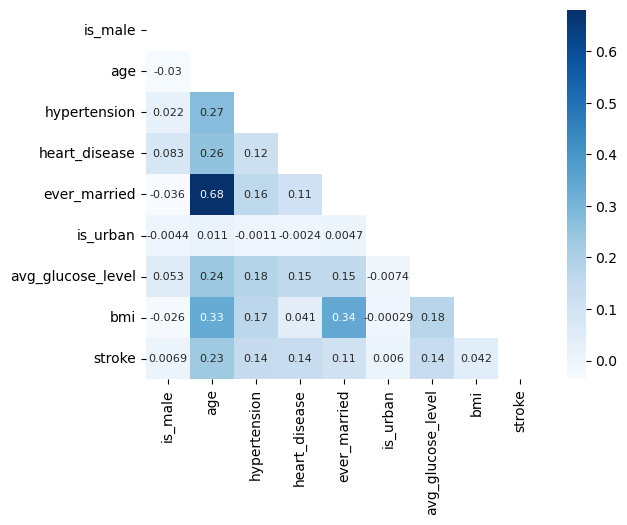

In [27]:
# Create correlation heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, cmap='Blues', annot=True, annot_kws={'size':8}, mask=mask)
plt.xticks(rotation=90)
plt.yticks(rotation=0);

> From the heatmap age is the most correlated with the target at 0.23 (weak correlation). Hypertension, Heart Disease, and Average Glucose Level are the second most correlated with the target at 0.14 (very weak correlation). It is of note that ever married is weakly correlated (0.11) with the target, however age and ever married are strongly correlated (0.68)

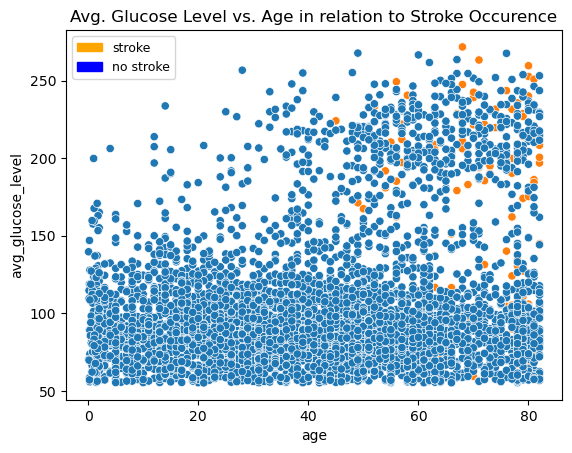

In [28]:
# scatter plot of glucose levels vs age with the relation to stroke
orange_label = mpatches.Patch(color='orange', label='stroke')
blue_label = mpatches.Patch(color='blue', label='no stroke')


sns.scatterplot(data=df, x='age', y='avg_glucose_level', hue='stroke')
plt.legend(handles=[orange_label, blue_label], fontsize=9);
plt.title('Avg. Glucose Level vs. Age in relation to Stroke Occurence');

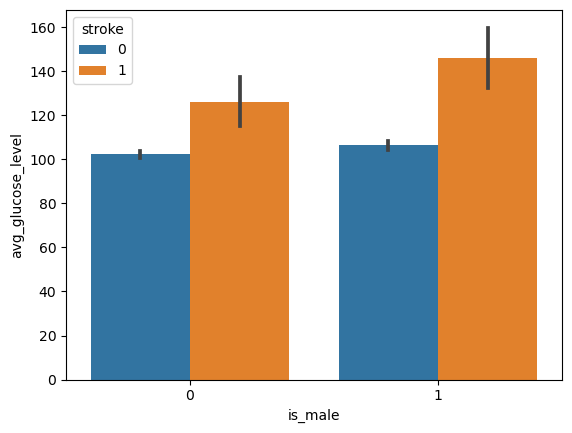

In [29]:
plot_cat('is_male', 'avg_glucose_level')

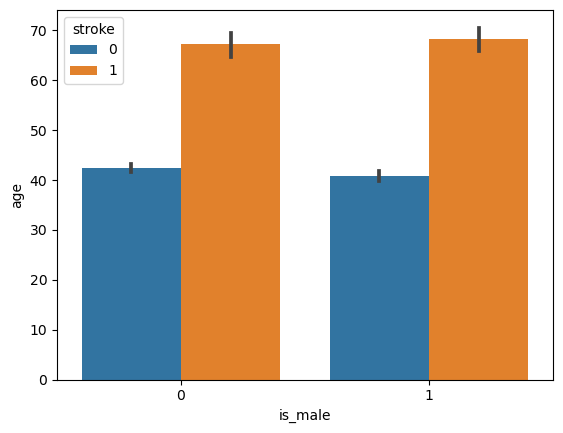

In [30]:
plot_cat('is_male', 'age')

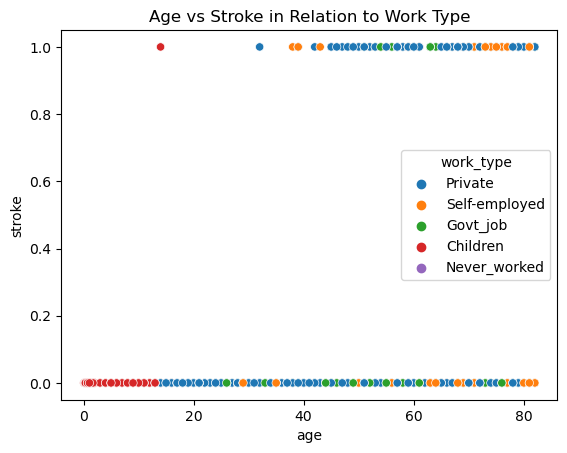

In [31]:
sns.scatterplot(data=df, x='age', y='stroke', hue='work_type').set(title='Age vs Stroke in Relation to Work Type');

In [32]:
# Percentage of values in 'work_type' column
df['work_type'].value_counts(normalize=True)

Private          0.572535
Self-employed    0.157905
Children         0.136716
Govt_job         0.128362
Never_worked     0.004482
Name: work_type, dtype: float64

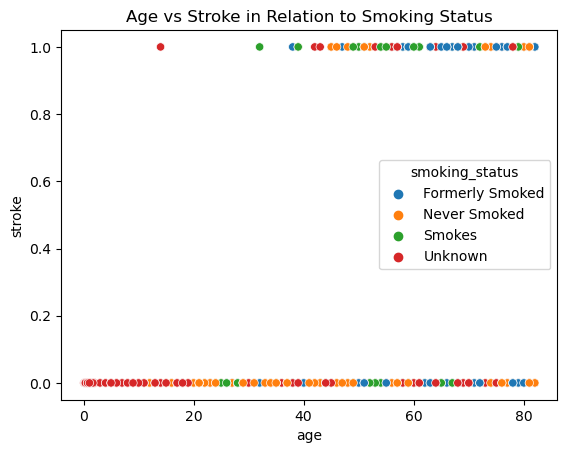

In [33]:
sns.scatterplot(data=df, x='age', y='stroke', hue='smoking_status').set(title='Age vs Stroke in Relation to Smoking Status');

In [34]:
# Percentage of values in 'smoking_status' column
df['smoking_status'].value_counts(normalize=True)

Never Smoked       0.377343
Unknown            0.302160
Formerly Smoked    0.170334
Smokes             0.150163
Name: smoking_status, dtype: float64

> The visualizations above (Age vs Stroke in relation to Work Type and Smoking Status) reinforce the correlation between age and the target, while showing both work type and smoking status are not strongly correlated. It worthy to note that Private work type makes up 57.2% of the 'work_type' column and Never Smoked makes up 37.7% of the 'smoking_status' column, which could skew how the visualization looks

### Is the Data Normally Distributed?

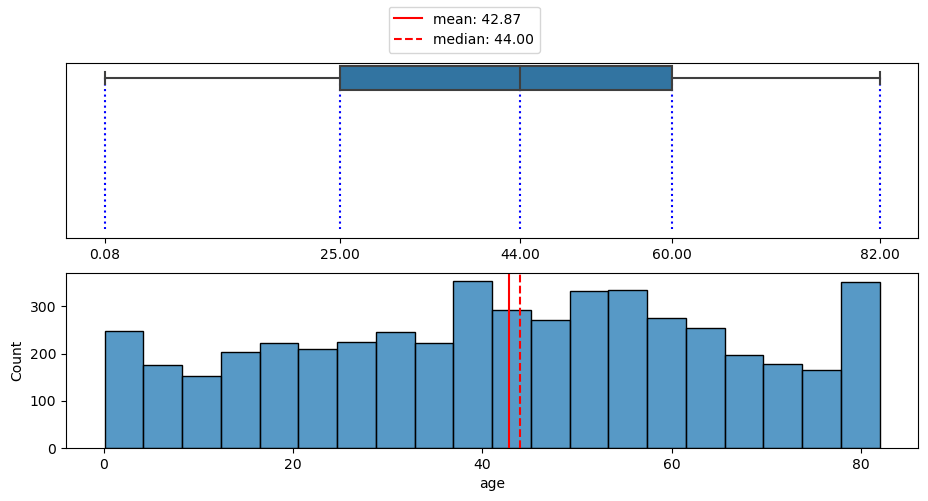

In [35]:
# Histogram and boxplot for 'age' column
plot_num('age')

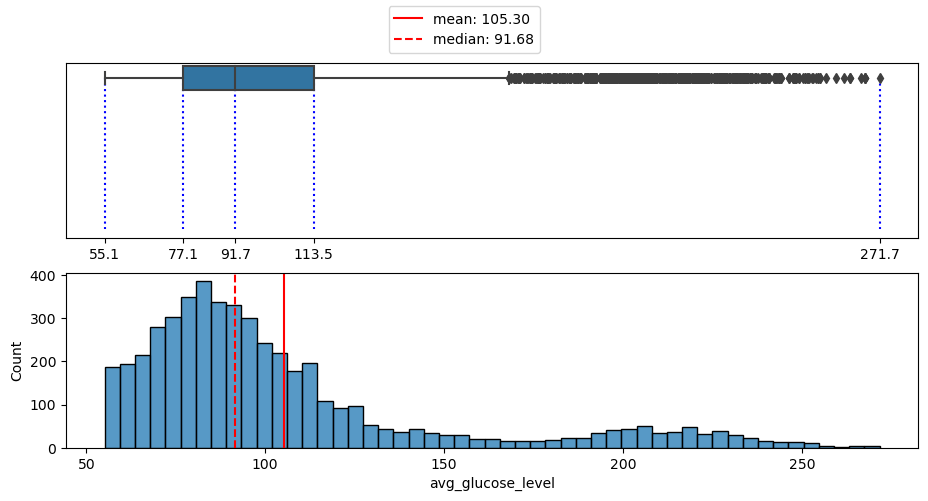

In [36]:
# Histogram and boxplot for 'avg_glucose_level' column
plot_num('avg_glucose_level')

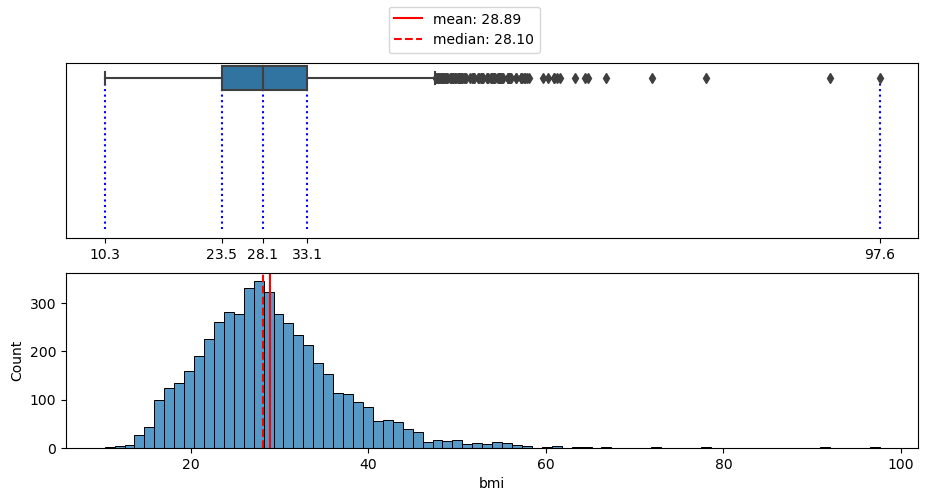

In [37]:
# Histogram and boxplot for 'bmi' column
plot_num('bmi')

> The histograms show that age is relatively normally distributed with no significant outliers, while BMI and avg glucose level contain many outliers giving the data a right skew

### Dealing with Outliers

In [38]:
# Use log transformation for 'avg_glucose_level' column
df['avg_glucose_level'] = np.log(df['avg_glucose_level'])
df['avg_glucose_level'].value_counts()

4.542017    6
4.290459    5
4.518304    5
4.520157    5
4.283449    5
           ..
4.923260    1
4.277499    1
4.583947    1
5.440641    1
4.445940    1
Name: avg_glucose_level, Length: 3851, dtype: int64

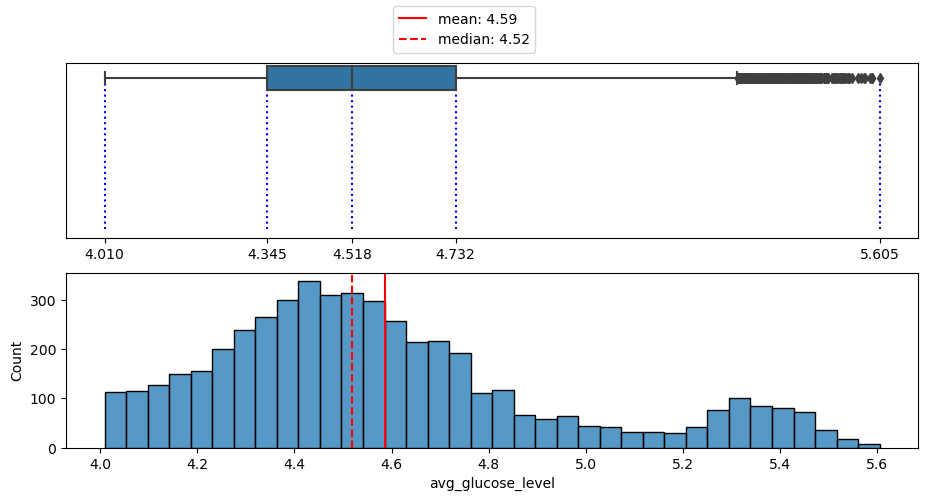

In [39]:
# Re-visualize
plot_num('avg_glucose_level')

In [40]:
# Remove values greater than 60 in 'bmi' colum
df = df.loc[df['bmi'] <= 60]
df['bmi'].value_counts()

28.7    41
28.4    38
26.1    37
26.7    37
27.7    37
        ..
48.7     1
53.5     1
50.5     1
40.7     1
14.9     1
Name: bmi, Length: 406, dtype: int64

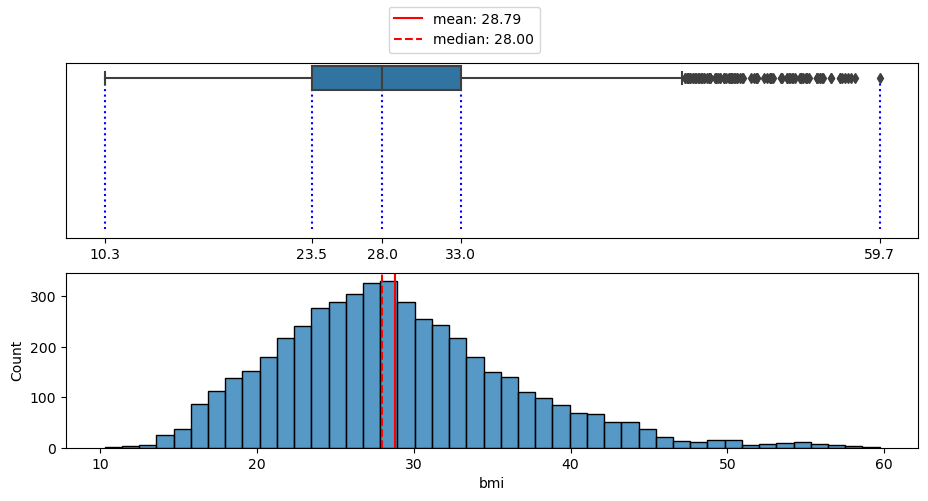

In [41]:
# Re-visualize
plot_num('bmi')

## Machine Learning Models

### Preprocessing

In [42]:
# Inspect dataframe
df_ml.info()
df_ml.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [43]:
# Remove unnecessary columns
df_ml.drop(columns='id', inplace=True)
df_ml.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [44]:
# Remove 'Other' from 'gender' column as there is only one value
df_ml = df_ml.loc[df_ml['gender']!='Other']
df_ml['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

In [45]:
# Use log transformation for 'avg_glucose_level' column
df_ml['avg_glucose_level'] = np.log(df_ml['avg_glucose_level'])
df_ml['avg_glucose_level'].value_counts()

4.542017    6
4.518304    5
4.520157    5
4.420766    5
4.290459    5
           ..
4.544039    1
4.717874    1
4.547541    1
4.559859    1
4.445940    1
Name: avg_glucose_level, Length: 3978, dtype: int64

In [46]:
# Remove values greater than 60 in 'bmi' colum
df_ml = df_ml.loc[df_ml['bmi'] <= 60]
df_ml['bmi'].value_counts()

28.7    41
28.4    38
26.1    37
26.7    37
27.7    37
        ..
48.7     1
53.5     1
50.5     1
40.7     1
14.9     1
Name: bmi, Length: 406, dtype: int64

In [47]:
# Remove missing values in the 'bmi' column
df_ml = df_ml.dropna()

In [48]:
# Determine class balance in the target
df['stroke'].value_counts(normalize=True)

0    0.957303
1    0.042697
Name: stroke, dtype: float64

> 95.7% of the target was negative (no stroke) and only 0.04% of the target was positive( stroke). We will need to address the class imbalance. This will be crucial to the success of the model since we will be most interested in correctly predicting the minority class

In [49]:
# Train test split
X = df_ml.drop(columns=['stroke'])
y = df_ml['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [50]:
# Create a baseline model pipeline
log_reg = LogisticRegression()

# Column Transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Column selectors
num_col = make_column_selector(dtype_include='number')
cat_col = make_column_selector(dtype_include='object')

# Tuples for pipeline
num_tuple = (scaler, num_col)
cat_tuple = (ohe, cat_col)

# Preprocessor object
prepocessor = make_column_transformer(num_tuple, cat_tuple, 
                                      verbose_feature_names_out=False)
prepocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                  verbose_feature_names_out=False)

### Baseline Models

In [51]:
# Instantiate and fit logistic regression model pipeline
log_reg = LogisticRegression()
log_reg_pipe = make_pipeline(prepocessor, log_reg)
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3525
           1       1.00      0.01      0.01       146

    accuracy                           0.96      3671
   macro avg       0.98      0.50      0.50      3671
weighted avg       0.96      0.96      0.94      3671



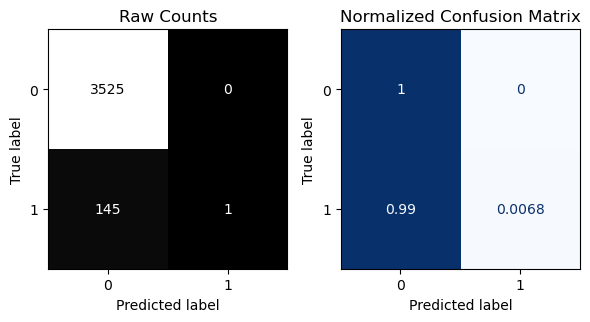


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1224
   macro avg       0.47      0.50      0.49      1224
weighted avg       0.90      0.95      0.92      1224



C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


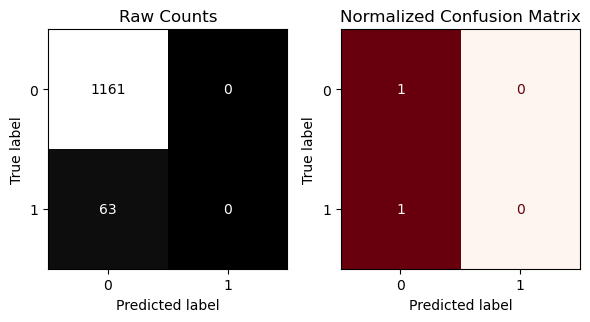

Training AUC: 0.5034246575342466
Testing AUC: 0.5


C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


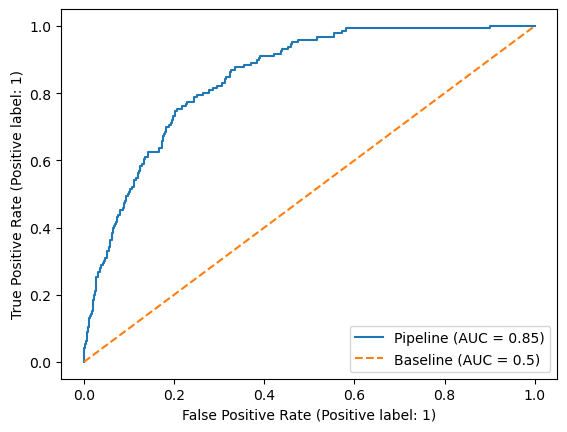

In [52]:
# Evaluate logistic regression model
evaluate_classification(log_reg_pipe, X_train, y_train, X_test, y_test)

In [53]:
# Instantiate and fit random forest model
rf = RandomForestClassifier()
rf_pipe = make_pipeline(prepocessor, rf)

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3525
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3671
   macro avg       1.00      1.00      1.00      3671
weighted avg       1.00      1.00      1.00      3671



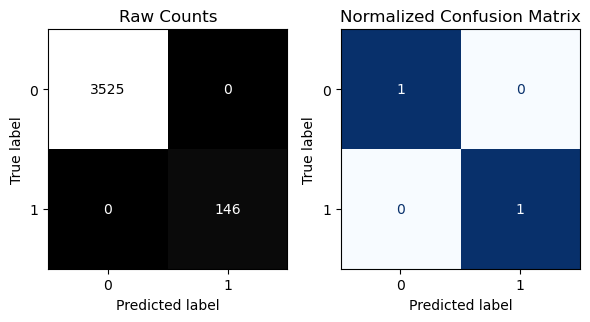


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       1.00      0.02      0.03        63

    accuracy                           0.95      1224
   macro avg       0.97      0.51      0.50      1224
weighted avg       0.95      0.95      0.93      1224



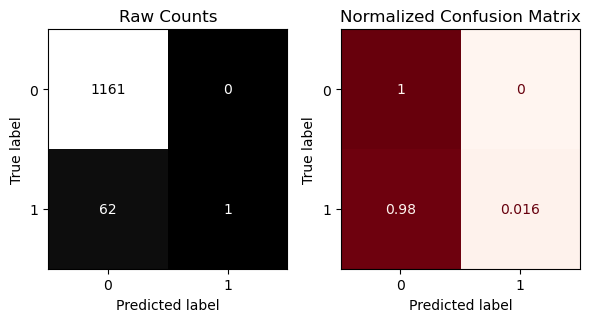

Training AUC: 1.0
Testing AUC: 0.5079365079365079


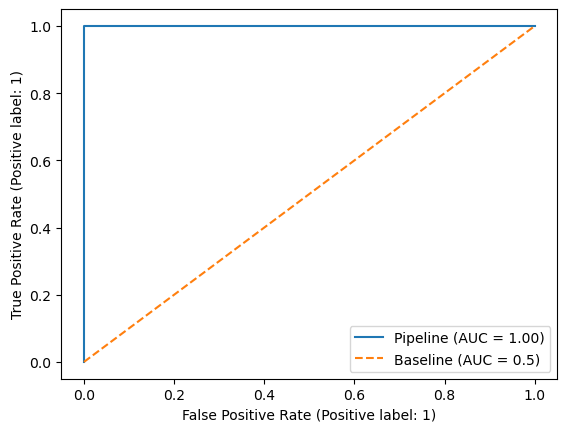

In [54]:
# Evaluate random forest model
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

In [55]:
# Instantiate and fit support vector model
svc = SVC()
svc_pipe = make_pipeline(prepocessor, svc)

svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('svc', SVC())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3525
           1       0.00      0.00      0.00       146

    accuracy                           0.96      3671
   macro avg       0.48      0.50      0.49      3671
weighted avg       0.92      0.96      0.94      3671



C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


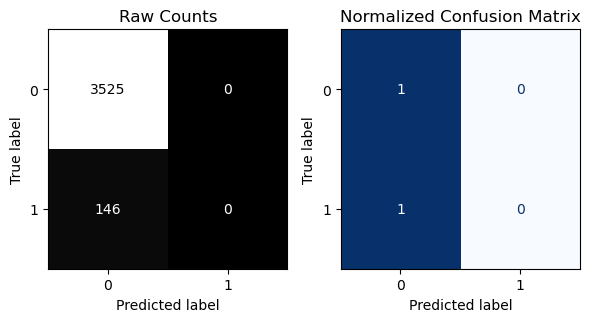

C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1161
           1       0.00      0.00      0.00        63

    accuracy                           0.95      1224
   macro avg       0.47      0.50      0.49      1224
weighted avg       0.90      0.95      0.92      1224



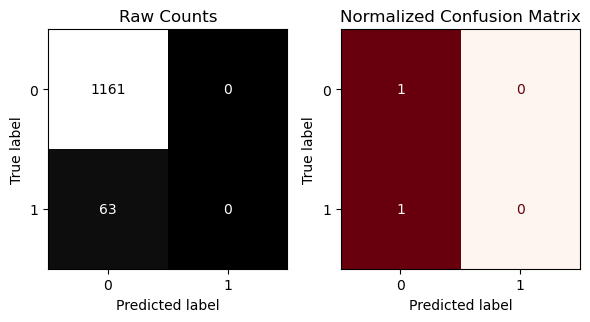

Training AUC: 0.5
Testing AUC: 0.5


C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


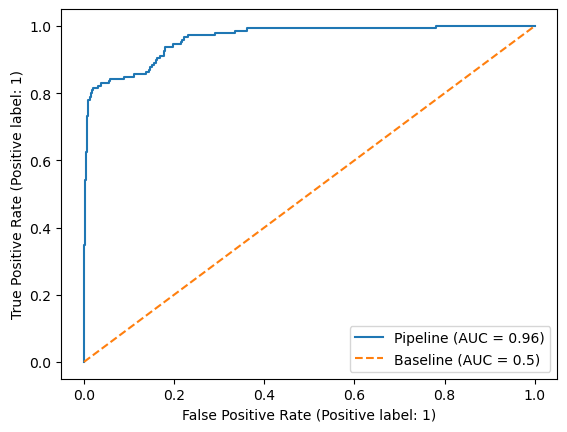

In [56]:
# Evaluate support vector model
evaluate_classification(svc_pipe, X_train, y_train, X_test, y_test)

In [57]:
# Instantiate and fit easy ensemble classifier
eec = EasyEnsembleClassifier()

eec_pipe = make_pipeline(prepocessor, eec)
eec_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      3525
           1       0.10      0.94      0.19       146

    accuracy                           0.67      3671
   macro avg       0.55      0.80      0.49      3671
weighted avg       0.96      0.67      0.77      3671



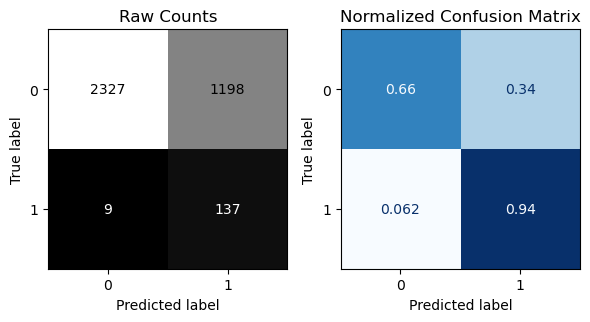


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1161
           1       0.12      0.86      0.21        63

    accuracy                           0.67      1224
   macro avg       0.56      0.76      0.50      1224
weighted avg       0.94      0.67      0.76      1224



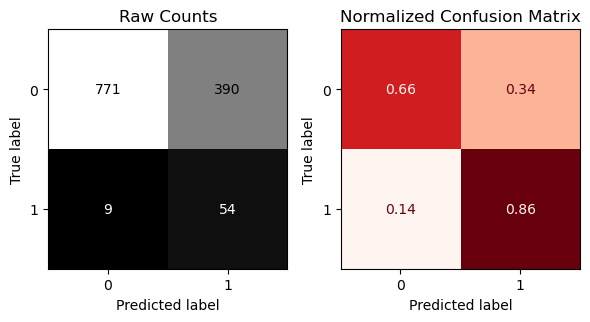

Training AUC: 0.7992490041775964
Testing AUC: 0.7606127722406792


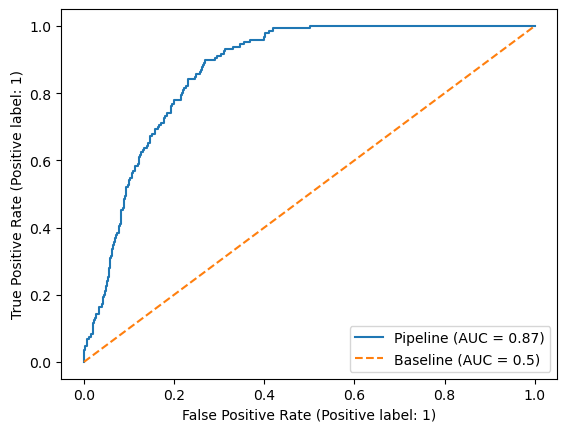

In [58]:
# Evaluate easy ensemble model
evaluate_classification(eec_pipe, X_train, y_train, X_test, y_test)

- Precision and F1 score in the logistic regression and support vector classifier the model were not able to be predicted, so they were set to zero. This could be from the imbalance in classes and the minority class being too small
- The random forest model is overfit on the training data showing that is had 100% accuracy with all true positives and negatives
- The easy ensemble classifier does not appear to be overfit, but still has too many false negatives and positives

> We can try to use oversampling to help the model perform better. Undersampling would not work in this case since the minority class is only 209 values, so we would loose too much data

### Baseline Models with SMOTE

In [59]:
# Instantiate smote and fit logistic regression model pipeline
smote = SMOTE()
lr_smote_pipe = make_pipeline(prepocessor, smote, log_reg)
lr_smote_pipe.fit(X_train, y_train)

C:\Users\hamma\anaconda3\envs\dojo-env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('logisticregression', LogisticRegression())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3525
           1       0.11      0.81      0.20       146

    accuracy                           0.74      3671
   macro avg       0.55      0.77      0.52      3671
weighted avg       0.95      0.74      0.82      3671



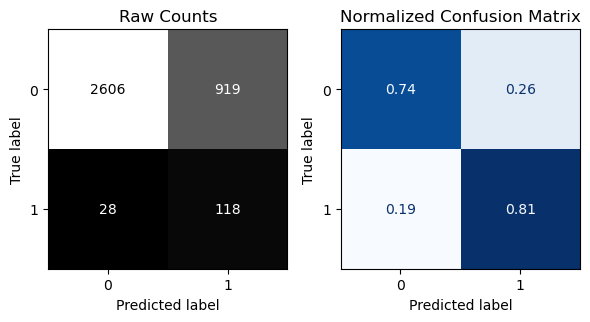


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      1161
           1       0.14      0.83      0.24        63

    accuracy                           0.73      1224
   macro avg       0.56      0.78      0.54      1224
weighted avg       0.94      0.73      0.81      1224



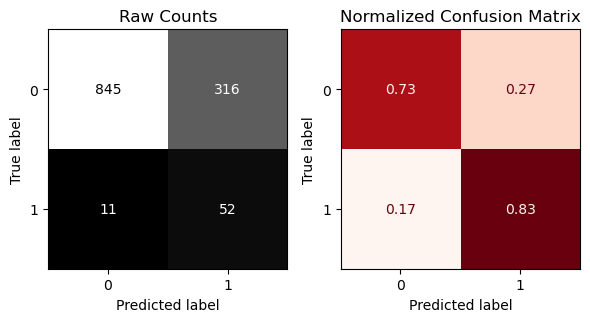

Training AUC: 0.773754979112018
Testing AUC: 0.7766088347483696


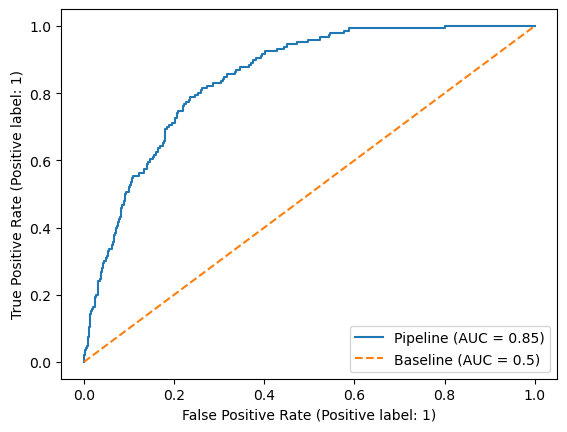

In [60]:
# Evaluate logistic regression model
evaluate_classification(lr_smote_pipe, X_train, y_train, X_test, y_test)

In [61]:
# Fit random forest model
rf_smote_pipe = make_pipeline(prepocessor, smote, rf)

rf_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('randomforestclassifier', RandomForestClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3525
           1       1.00      1.00      1.00       146

    accuracy                           1.00      3671
   macro avg       1.00      1.00      1.00      3671
weighted avg       1.00      1.00      1.00      3671



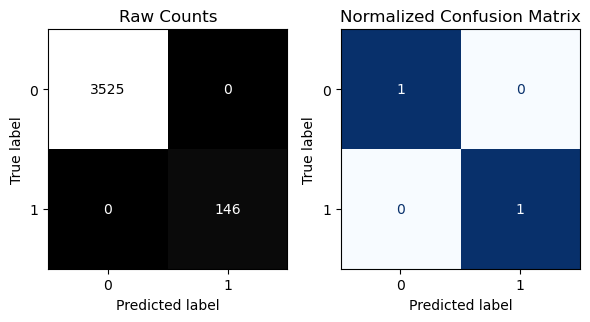


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1161
           1       0.18      0.10      0.12        63

    accuracy                           0.93      1224
   macro avg       0.56      0.54      0.54      1224
weighted avg       0.91      0.93      0.92      1224



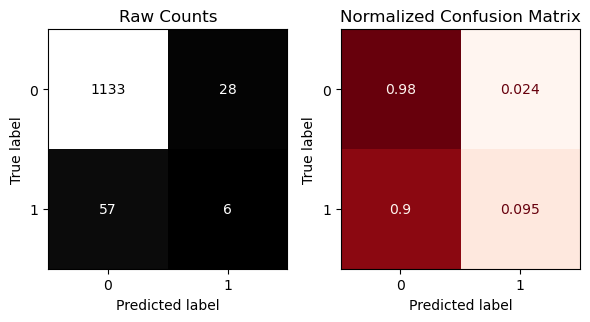

Training AUC: 1.0
Testing AUC: 0.5355604774209426


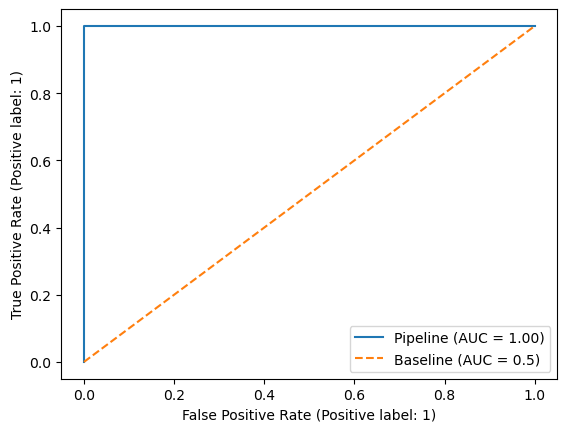

In [62]:
# Evaluate random forest model
evaluate_classification(rf_smote_pipe, X_train, y_train, X_test, y_test)

In [63]:
# Fit support vector model
svc_smote_pipe = make_pipeline(prepocessor, smote, svc)

svc_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()), ('svc', SVC())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3525
           1       0.19      0.84      0.31       146

    accuracy                           0.85      3671
   macro avg       0.59      0.85      0.61      3671
weighted avg       0.96      0.85      0.89      3671



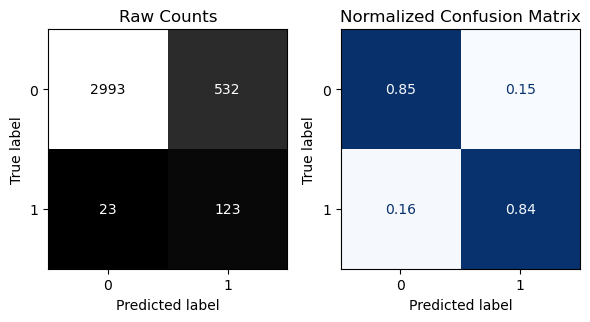


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.85      0.90      1161
           1       0.15      0.49      0.23        63

    accuracy                           0.83      1224
   macro avg       0.56      0.67      0.57      1224
weighted avg       0.93      0.83      0.87      1224



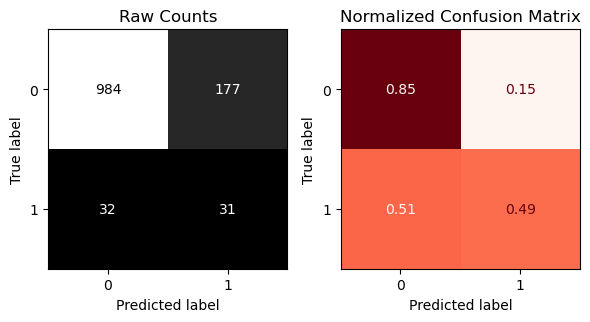

Training AUC: 0.8457718838045274
Testing AUC: 0.6698043558508675


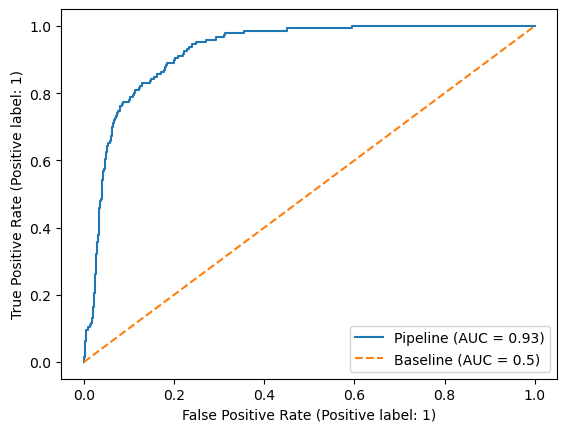

In [64]:
# Evaluate support vector model
evaluate_classification(svc_smote_pipe, X_train, y_train, X_test, y_test)

In [65]:
# Fit easy ensemble classifier
eec_smote_pipe = make_pipeline(prepocessor, smote, eec)
eec_smote_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE()),
                ('easyensembleclassifier', EasyEnsembleClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3525
           1       0.13      0.39      0.20       146

    accuracy                           0.87      3671
   macro avg       0.55      0.64      0.56      3671
weighted avg       0.94      0.87      0.90      3671



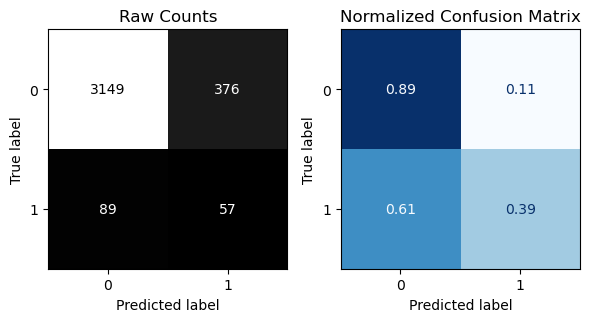


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      1161
           1       0.16      0.35      0.22        63

    accuracy                           0.87      1224
   macro avg       0.56      0.62      0.57      1224
weighted avg       0.92      0.87      0.89      1224



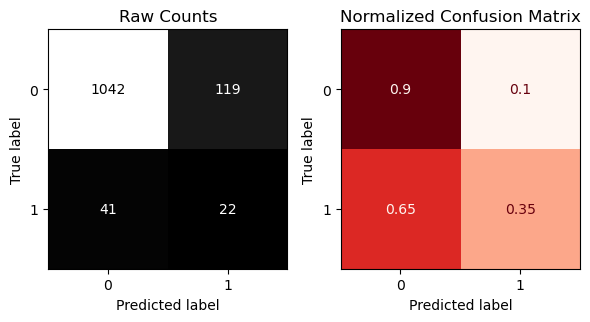

Training AUC: 0.6418721461187215
Testing AUC: 0.623354251261228


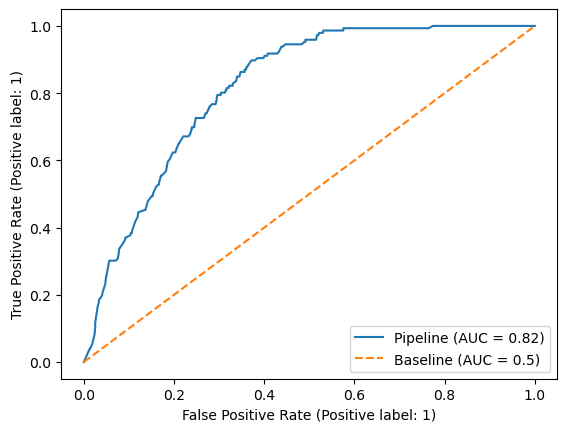

In [66]:
# Evaluate easy ensemble model
evaluate_classification(eec_smote_pipe, X_train, y_train, X_test, y_test)

 - Using SMOTE increased the models performance
 - The random forest model is still overfit to the training data
 - The logistic regression model performed the worst with type 2 errors, but performed the best with type 1 errors

> We will tune the support vector and easy ensemble models to see if we can improve the type 1 errors while keeping the type 2 errors low. If this fails we can try tuning the logistic regression model

### Hyperparameter Tuning

In [67]:
# Support Vector Model

# Check parameters
svc_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                     verbose_feature_names_out=False)),
  ('smote', SMOTE()),
  ('svc', SVC())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                 ('onehotencoder',
                                  OneHotEncoder(ha

In [68]:
# Parameter Grid
param_grid = {'svc__C': [0.1,1, 10, 100],
              'svc__class_weight': [None, 'balanced'],
              'svc__gamma': [1,0.1,0.01,0.001],
              'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

In [69]:
# Instatiate Gridsearch model
svc_gs = GridSearchCV(svc_smote_pipe, param_grid, verbose=2)
svc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   0.6s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   0.5s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   0.6s
[CV] END svc__C=0.1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; t

[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=rbf; total time=   0.8s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   0.7s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   0.5s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   0.6s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   0.6s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   0.7s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   1.0s
[CV] END svc__C=0.1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.

[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.5s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=rbf; total time=   0.4s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   2.1s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   1.9s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   2.4s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   2.3s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   2.5s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=1, svc__class_weight=None, svc__gamma=1, 

[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   2.1s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   2.5s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=poly; total time=   2.1s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   0.5s
[CV] END svc__C=1, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   0.5s
[

[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=poly; total time=   9.0s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.9s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   1.1s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   1.2s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   1.2s
[CV] END svc__C=10, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   1.1s
[CV] END svc__C=10, svc__cl

[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.8s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=sigmoid; total time=   0.9s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   1.1s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   1.2s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   1.3s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   1.1s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   1.2s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=10, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total ti

[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.7s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=sigmoid; total time=   0.6s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   5.3s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   6.3s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   5.9s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   5.1s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=1, svc__kernel=linear; total time=   5.7s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=100, svc__class_weight=None, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=100, 

[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   5.1s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   6.0s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   5.9s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   5.0s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=1, svc__kernel=linear; total time=   5.3s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total time=   0.3s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END svc__C=100, svc__class_weight=balanced, svc__gamma=0.1, svc__kernel=rbf; tota

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                                          verbose_feature_names_out=False)),
                                       ('smote', SMOTE()), ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__class_weight': [None, 'balanced'],
                         'svc__gamma': [1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             verbose=2)

In [70]:
svc_gs.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__gamma': 0.001,
 'svc__kernel': 'poly'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      3525
           1       0.26      0.12      0.16       146

    accuracy                           0.95      3671
   macro avg       0.61      0.55      0.57      3671
weighted avg       0.94      0.95      0.94      3671



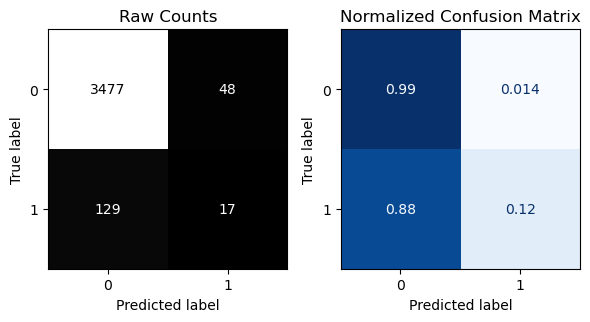


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1161
           1       0.21      0.11      0.15        63

    accuracy                           0.93      1224
   macro avg       0.58      0.54      0.56      1224
weighted avg       0.91      0.93      0.92      1224



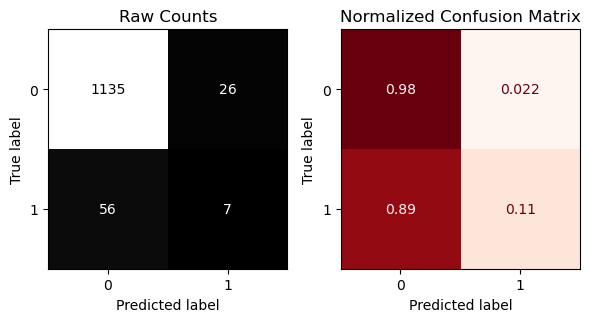

Training AUC: 0.551410667443894
Testing AUC: 0.5443583118001722


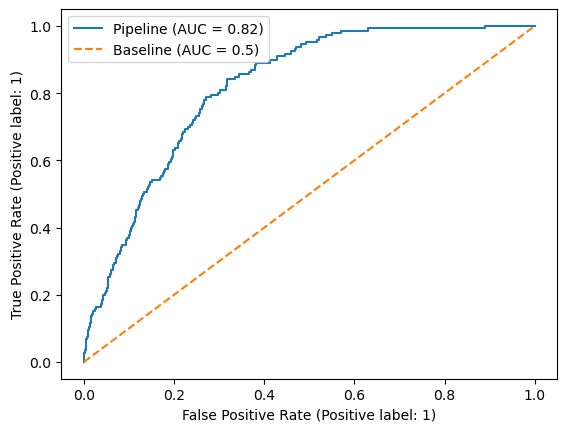

In [71]:
# Fit and evaluate best model
best_svc_gs = svc_gs.best_estimator_
best_svc_gs.fit(X_train, y_train)

# Evaluate support vector classifier model
evaluate_classification(best_svc_gs, X_train, y_train, X_test, y_test)

In [72]:
# Easy Ensemble Classifier
# Check parameters
eec_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                     verbose_feature_names_out=False)),
  ('smote', SMOTE()),
  ('easyensembleclassifier', EasyEnsembleClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                 ('onehotencoder',
            

In [73]:
# Parameter grid
param_grid = {'easyensembleclassifier__n_estimators': [30, 40, 50, 60]}

In [74]:
# Instatiate Gridsearch model
eec_gs = GridSearchCV(eec_smote_pipe, param_grid, verbose=2)
eec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ............easyensembleclassifier__n_estimators=30; total time=   5.5s
[CV] END ............easyensembleclassifier__n_estimators=30; total time=   5.5s
[CV] END ............easyensembleclassifier__n_estimators=30; total time=   5.5s
[CV] END ............easyensembleclassifier__n_estimators=30; total time=   5.5s
[CV] END ............easyensembleclassifier__n_estimators=30; total time=   5.5s
[CV] END ............easyensembleclassifier__n_estimators=40; total time=   7.4s
[CV] END ............easyensembleclassifier__n_estimators=40; total time=   7.5s
[CV] END ............easyensembleclassifier__n_estimators=40; total time=   7.3s
[CV] END ............easyensembleclassifier__n_estimators=40; total time=   7.3s
[CV] END ............easyensembleclassifier__n_estimators=40; total time=   7.3s
[CV] END ............easyensembleclassifier__n_estimators=50; total time=   9.2s
[CV] END ............easyensembleclassifier__n_es

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                                          verbose_feature_names_out=False)),
                                       ('smote', SMOTE()),
                                       ('easyensembleclassifier',
                                        EasyEnsembleClassifier())]),
             param_grid={'easyensembleclassifier__n_estimators': [30, 40, 50,
                                                                  60]},
             verbose=2)

In [75]:
eec_gs.best_params_

{'easyensembleclassifier__n_estimators': 60}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3525
           1       0.13      0.36      0.19       146

    accuracy                           0.88      3671
   macro avg       0.55      0.63      0.56      3671
weighted avg       0.94      0.88      0.90      3671



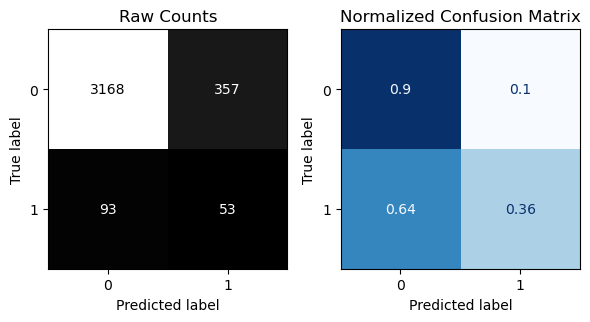


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      1161
           1       0.16      0.38      0.22        63

    accuracy                           0.86      1224
   macro avg       0.56      0.64      0.57      1224
weighted avg       0.92      0.86      0.89      1224



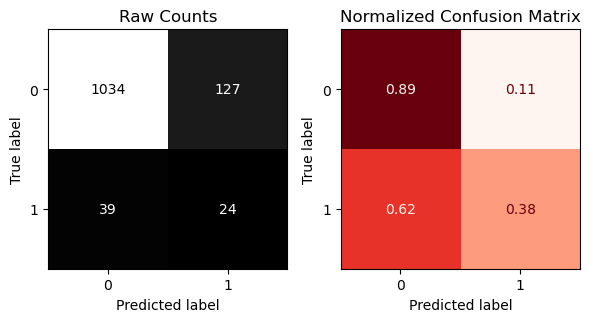

Training AUC: 0.630868551442728
Testing AUC: 0.6357819613633567


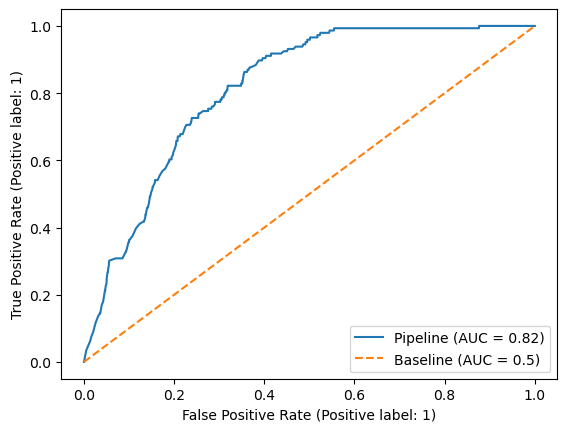

In [76]:
# Fit and evaluate the best model
best_eec_gs = eec_gs.best_estimator_
best_eec_gs.fit(X_train, y_train)

# Evaluate easy ensemble classifier model
evaluate_classification(best_eec_gs, X_train, y_train, X_test, y_test)

In [77]:
# Logistic Regression
# Search Parameters
lr_smote_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                     verbose_feature_names_out=False)),
  ('smote', SMOTE()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                 ('onehotencoder',
                    

In [78]:
param_grid = {'logisticregression__penalty' : ['l1', 'l2'],
              'logisticregression__C' : [100, 10, 1.0, 0.1, 0.001],
              'logisticregression__solver' : ['liblinear'],
              'logisticregression__max_iter': [1000, 100]}

In [79]:
# Fit and evaluate logistic regression
lr_gs = GridSearchCV(lr_smote_pipe, param_grid, verbose=2)
lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=100, logisticregression__max_iter=1000, logisticregression__penalty=l2, logisticregression__solver=liblinea

[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l1, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticregression__max_iter=100, logisticregression__penalty=l2, logisticregression__solver=liblinear; total time=   0.0s
[CV] END logisticregression__C=1.0, logisticre

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4F70>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000203BC1B4D90>)],
                                                          verbose_feature_names_out=False)),
                                       ('smote', SMOTE()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [100, 10, 1.0, 0.1, 0.001],
                         'logisticregression__max_iter': [1000, 100],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear']},
             verbose=2)

In [80]:
lr_gs.best_params_

{'logisticregression__C': 1.0,
 'logisticregression__max_iter': 100,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      3525
           1       0.11      0.79      0.20       146

    accuracy                           0.74      3671
   macro avg       0.55      0.77      0.52      3671
weighted avg       0.95      0.74      0.82      3671



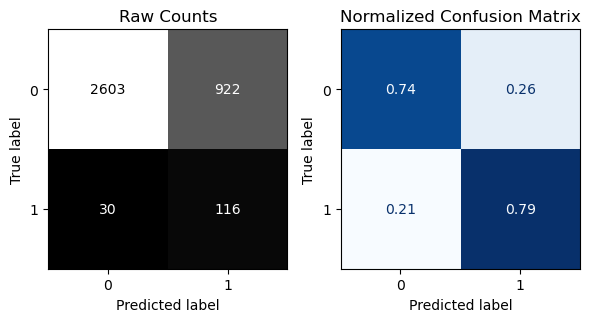


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.74      0.84      1161
           1       0.14      0.79      0.24        63

    accuracy                           0.74      1224
   macro avg       0.56      0.77      0.54      1224
weighted avg       0.94      0.74      0.81      1224



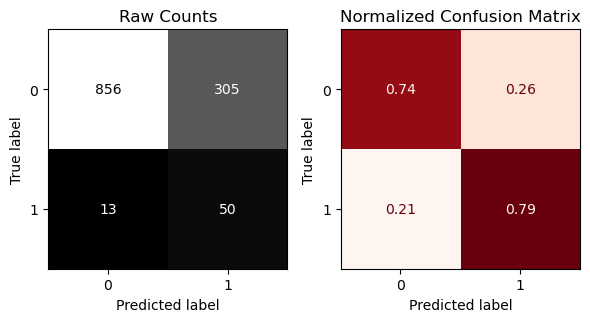

Training AUC: 0.7664801321286312
Testing AUC: 0.7654731143103235


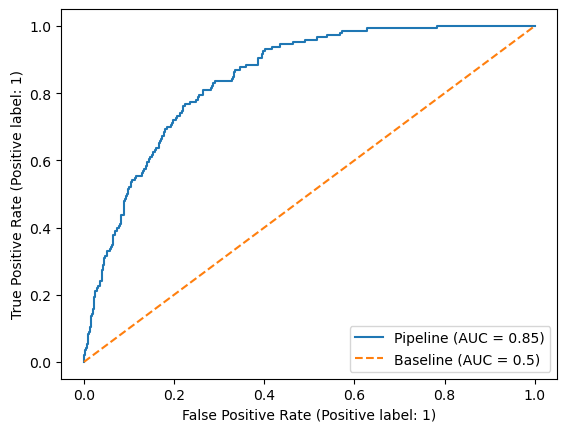

In [81]:
best_lr_gs = lr_gs.best_estimator_
best_lr_gs.fit(X_train, y_train)

# Evaluate logistic regression model
evaluate_classification(best_lr_gs, X_train, y_train, X_test, y_test)

> The metric we are focused on in the models is reducing type 2 errors. Predicting that a patient is not predicted to have a stroke when they should be could be detrimental. The model with the lowest type 2 errors is the support vector classifier (2.4%). It is of note that the type 1 rate in this model is very high (87%)